# Data Preprocessing

## Estrazione concetti da NOTEEVENTS

In [1]:
import sys
import re
import pandas as pd
import matplotlib.pyplot as plt

import medspacy

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords

from icdmappings import Mapper

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\giuse\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\giuse\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\giuse\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Read the NOTEEVENTS and PATIENTS tables
note = pd.read_csv(
    "data/NOTEEVENTS.csv",
    dtype={"SUBJECT_ID": str, "HADM_ID": str, "CATEGORY": str,"CHARTDATE": str, "TEXT": str},
    parse_dates=["CHARTDATE"],
    infer_datetime_format=True
)

patient = pd.read_csv(
    "data/PATIENTS.csv",
    dtype={"SUBJECT_ID": str, "GENDER": str, "DOB": str, "DOD": str, "DOD_HOSP": str, "DOD_SSN": str},
    parse_dates=["DOB", "DOD", "DOD_HOSP", "DOD_SSN"],
    infer_datetime_format=True
)

### Estrazione note d'interesse

In [3]:
print(note.shape)
note.head(5)

(2083180, 11)


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [4]:
print(patient.shape)
patient.head(5)

(46520, 8)


,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13,NaT,NaT,NaT,0
1,235,250,F,2164-12-27,2188-11-22,2188-11-22,NaT,1
2,236,251,M,2090-03-15,NaT,NaT,NaT,0
3,237,252,M,2078-03-06,NaT,NaT,NaT,0
4,238,253,F,2089-11-26,NaT,NaT,NaT,0


In [17]:
# Select only Discharge Summary notes written as Reports
note_filtered = note[(note['CATEGORY'] == 'Discharge summary') & (note['DESCRIPTION'] == 'Report')]
# Remove any notes with errors
note_filtered = note_filtered[note_filtered['ISERROR'] != 1]
# Remove notes with missing values
note_filtered = note_filtered.dropna(subset=["SUBJECT_ID", "HADM_ID", "TEXT"])
# Calculate the number of tokens for each note and select only notes with at least 1000 tokens
note_filtered['TOKEN_COUNT'] = note_filtered['TEXT'].str.len() / 4
note_filtered = note_filtered[note_filtered['TOKEN_COUNT'] >= 1000]

In [18]:
# Print the original dimensions of the dataframe
print("Original dimensions: " + str(note_filtered.shape) + "\n")

# Print the number of unique values for each column
print("Stats: " + str(note_filtered.nunique()) + "\n")

# Drop duplicates based on the 'TEXT' column and update the dataframe
note_filtered.drop_duplicates(subset='TEXT', inplace=True)

# Print the dimensions of the dataframe after removing duplicates
print("Dimensions after processing: " + str(note_filtered.shape) + "\n")

Original dimensions: (51278, 12)

Stats: ROW_ID         51278
SUBJECT_ID     38890
HADM_ID        49975
CHARTDATE      27185
CHARTTIME          0
STORETIME          0
CATEGORY           1
DESCRIPTION        1
CGID               0
ISERROR            0
TEXT           51215
TOKEN_COUNT    16376
dtype: int64

Dimensions after processing: (51215, 12)



In [19]:
print(note_filtered.shape)
note_filtered.head(5)

(51215, 12)


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,TOKEN_COUNT
1,175,13702,107527,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...,3158.25
2,176,13702,167118,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...,2434.00
3,177,13702,196489,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...,4284.50
4,178,26880,135453,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...,3624.75
5,179,53181,170490,2172-03-08,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2172-3-5**] D...,1951.75


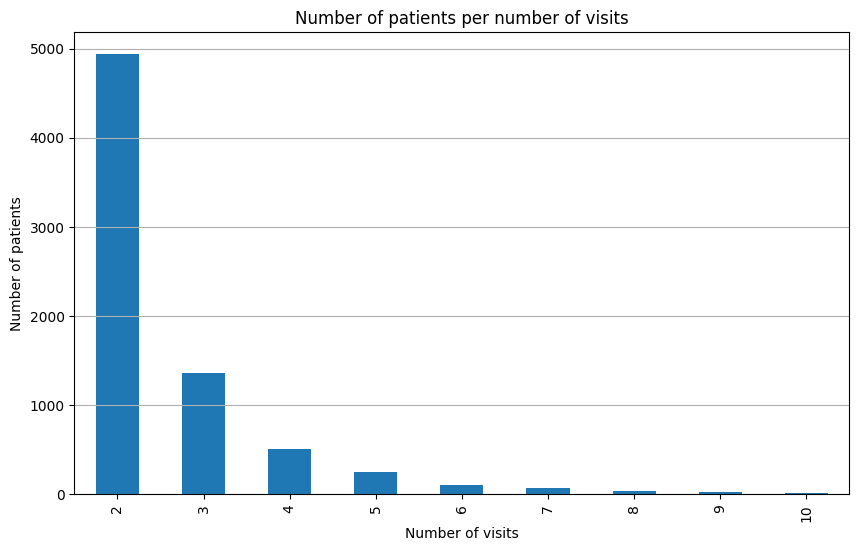

In [20]:
# Count the number of visits per patient
visit_counts = note_filtered.groupby('SUBJECT_ID').size()

# Count the number of patients per number of visits
patients_per_visit_count = visit_counts.value_counts().sort_index()

# Create a bar chart
plt.figure(figsize=(10, 6))
patients_per_visit_count[1:10].plot(kind='bar')
plt.title('Number of patients per number of visits')
plt.xlabel('Number of visits')
plt.ylabel('Number of patients')
plt.grid(axis='y')

# Show the chart
plt.show()

In [35]:
# Group the notes by patient
group_note = note_filtered.groupby("SUBJECT_ID")

# Calculate the number of visits (discharge summaries) for each patient
visits_per_patient = group_note['HADM_ID'].size()

# Filter patients who have exactly 3 visits
patients_with_at_least_two_visits = visits_per_patient[visits_per_patient == 3].index

# Create a new DataFrame containing only patients with exactly 3 visits
note_filtered_multiple_visits = note_filtered[note_filtered["SUBJECT_ID"].isin(patients_with_at_least_two_visits)]

# Reset the index of the new DataFrame
note_filtered_multiple_visits = note_filtered_multiple_visits.reset_index(drop=True)

In [36]:
print(note_filtered_multiple_visits.shape)
note_filtered_multiple_visits.head(5)

(4077, 12)


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,TOKEN_COUNT
0,175,13702,107527,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...,3158.25
1,176,13702,167118,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...,2434.00
2,177,13702,196489,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...,4284.50
3,185,1136,139574,2192-05-23,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2192-4-19**] ...,3769.50
4,230,9805,188132,2130-02-09,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2130-2-3**] D...,1303.75


In [37]:
note_filtered_multiple_visits.set_index("ROW_ID", inplace=True)

In [38]:
note_filtered_multiple_visits.head(5)

,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,TOKEN_COUNT
ROW_ID,,,,,,,,,,,
175,13702,107527,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...,3158.25
176,13702,167118,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...,2434.00
177,13702,196489,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...,4284.50
185,1136,139574,2192-05-23,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2192-4-19**] ...,3769.50
230,9805,188132,2130-02-09,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2130-2-3**] D...,1303.75


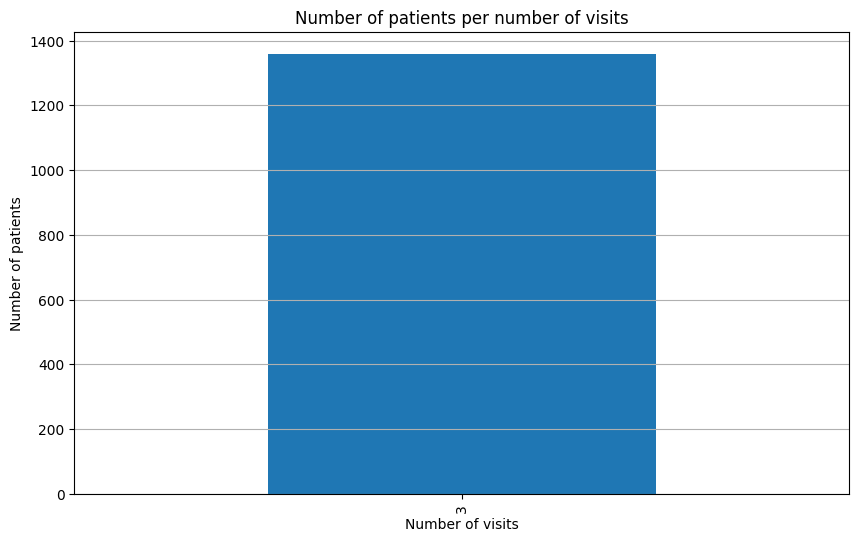

In [39]:
# Count the number of visits per patient
visit_counts = note_filtered_multiple_visits.groupby('SUBJECT_ID').size()

# Count the number of patients per number of visits
patients_per_visit_count = visit_counts.value_counts().sort_index()

# Create a bar chart
plt.figure(figsize=(10, 6))
patients_per_visit_count[:10].plot(kind='bar')
plt.title('Number of patients per number of visits')
plt.xlabel('Number of visits')
plt.ylabel('Number of patients')
plt.grid(axis='y')

# Show the chart
plt.show()

In [40]:
# Print the number of unique values for each column
print("Stats: " + str(note_filtered_multiple_visits.nunique()) + "\n")

Stats: SUBJECT_ID     1359
HADM_ID        3780
CHARTDATE      3799
CHARTTIME         0
STORETIME         0
CATEGORY          1
DESCRIPTION       1
CGID              0
ISERROR           0
TEXT           4077
TOKEN_COUNT    3579
dtype: int64



### Estrazione delle sezioni e pulizia del testo delle note

In [41]:
nlp = medspacy.load()

In [42]:
nlp.pipe_names

['medspacy_pyrush', 'medspacy_target_matcher', 'medspacy_context']

In [43]:
sectionizer = nlp.add_pipe("medspacy_sectionizer")

In [44]:
nlp.pipe_names

['medspacy_pyrush',
 'medspacy_target_matcher',
 'medspacy_context',
 'medspacy_sectionizer']

In [45]:
def section_extraction(text):
    doc = nlp(text)
    i = 0
    note_prep = ""
    for title in doc._.section_titles:
        if str(title).lower() == 'chief complaint:':
            note_prep += str(doc._.section_spans[i])
        if str(title).lower() == 'history of present illness:' or str(title).lower() == 'history:':
            note_prep += str(doc._.section_spans[i])
        if str(title).lower() == 'past medical history:':
            note_prep += str(doc._.section_spans[i])
        if str(title).lower() == 'discharge medications:':
            note_prep += str(doc._.section_spans[i])
        if str(title).lower() == 'brief hospital course:' or str(title).lower() == 'hospital course:':
            note_prep += str(doc._.section_spans[i])
        if str(title).lower() == 'discharge diagnoses:':
            note_prep += str(doc._.section_spans[i])
        i += 1

    return note_prep

In [46]:
# Creation of a new column for the cleaned text
note_filtered_multiple_visits['CLEANED TEXT'] = ''

# Iteration over the rows of the DataFrame
total_rows = len(note_filtered_multiple_visits)
for i, (index, row) in enumerate(note_filtered_multiple_visits.iterrows()):
    # Get the text from the desired column (e.g. 'Text')
    text = row['TEXT']
    
    # Extract the sections from the text
    cleaned_text = section_extraction(text)
    
    # Save the cleaned text in the new 'Cleaned Text' column
    note_filtered_multiple_visits.at[index, 'CLEANED TEXT'] = cleaned_text
    
    # Calculate the completion percentage
    percent_complete = ((i + 1) / total_rows) * 100
    # Print the completion percentage overwriting the current line
    sys.stdout.write(f"\rCompleted: {percent_complete:.2f}%")
    sys.stdout.flush()

Completed: 2.99%

KeyboardInterrupt: 

In [47]:
def tokenize_and_lemmatize(text):
    # Tokenizzazione delle parole
    tokens = word_tokenize(text)
    
    # Inizializzazione del lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Rimozione delle stopwords e simboli
    stop_words = set(stopwords.words('english'))
    symbols = ['[', '*', '+']
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words and not re.match(r'^\W+$', token) and not any(symbol in token for symbol in symbols)]
    
    # Lemmatizzazione delle parole
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # Riaccorpamento del testo lemmatizzato
    lemmatized_text = ' '.join(lemmatized_tokens)
    
    return lemmatized_text

In [ ]:
# Creation of a new column for the lemmatized text
note_filtered_multiple_visits['LEMMATIZED TEXT'] = ''

# Iteration over the rows of the DataFrame
total_rows = len(note_filtered_multiple_visits)
for i, (index, row) in enumerate(note_filtered_multiple_visits.iterrows()):
    # Get the text from the desired column (e.g. 'Text')
    text = row['CLEANED TEXT']
    
    # Tokenization and lemmatization of the text
    lemmatized_text = tokenize_and_lemmatize(text)
    
    # Save the lemmatized text in the new 'Lemmatized Text' column
    note_filtered_multiple_visits.at[index, 'LEMMATIZED TEXT'] = lemmatized_text
    
    # Calculate the completion percentage
    percent_complete = ((i + 1) / total_rows) * 100
    # Print the completion percentage overwriting the current line
    sys.stdout.write(f"\rCompleted: {percent_complete:.2f}%")
    sys.stdout.flush()

### NER + EL con MedCAT

In [ ]:
from medcat.cat import CAT
from medcat.cdb import CDB
from medcat.vocab import Vocab
from medcat.meta_cat import MetaCAT

In [ ]:
DATA_DIR = "./data_umls/"
vocab_path = DATA_DIR + "vocab.dat"
cdb_path = DATA_DIR + "cdb.dat"

In [ ]:
# Create and load the CDB (Concept Database)
cdb = CDB.load(cdb_path)

# Create and load the Vocabulary
vocab = Vocab.load(vocab_path)

# Load model for MetaAnnotations (optional)
mc_status = MetaCAT.load("./data_umls/meta_Status/")

In [ ]:
# Create CAT - the main class from medcat used for concept annotation
cat = CAT(cdb=cdb, config=cdb.config, vocab=vocab, meta_cats=[mc_status])

In [ ]:
# Detect only the following entity:
    # bpoc|T023|Body Part, Organ, or Organ Component
    # lbtr|T034|Laboratory or Test Result
    # patf|T046|Pathologic Function
    # dsyn|T047|Disease or Syndrome
    # mobd|T048|Mental or Behavioral Dysfunction
    # lbpr|T059|Laboratory Procedure
    # diap|T060|Diagnostic Procedure
    # topp|T061|Therapeutic or Preventive Procedure
    # phsu|T121|Pharmacologic Substance ---> SE LO AGGIUNGO MI METTE ANCHE ALTRA ROBA TIPO VITAMINE, ENZIMI, ETC.
    # sosy|T184|Sign or Symptom

type_ids_filter = ['T047','T048','T184']
cui_filters = set()
for type_ids in type_ids_filter:
    cui_filters.update(cat.cdb.addl_info['type_id2cuis'][type_ids])
cat.cdb.config.linking['filters']['cuis'] = cui_filters

In [ ]:
color_dict = {
    'Body Part, Organ, or Organ Component': '#FFCE80',  # Arancione pastello
    'Laboratory or Test Result': '#FFF9C4',             # Giallo chiaro
    'Disease or Syndrome': '#B5EAD7',                   # Verde acqua chiaro
    'Mental or Behavioral Dysfunction': '#F0B2FF',      # Viola pastello
    'Laboratory Procedure': '#D0D9FF',                  # Blu chiaro
    'Diagnostic Procedure': '#FFD9EC',                  # Rosa chiaro
    'Therapeutic or Preventive Procedure': '#C4FFFF',   # Azzurro chiaro
    'Pharmacologic Substance': '#FFDAB9',               # Pesca pastello
    'Sign or Symptom': '#FFC4F3',                       # Magenta chiaro
    'Pathologic Function': '#B5EAD7'                    # Verde acqua chiaro
}

In [ ]:
# Initialize an empty list to store the extracted entities
entities_lemma = []

# Get the total number of rows in the DataFrame
total_rows = len(note_filtered_multiple_visits)

# Loop over each row in the DataFrame
for i, row in enumerate(note_filtered_multiple_visits.index):
    # Extract the named entities from the text in the current row
    ner = cat.get_entities(note_filtered_multiple_visits['TEXT'][row])
    # Add the row ID, subject ID, and HADM ID to the named entities dictionary
    ner['row_id'] = row
    ner['subject_id'] = note_filtered_multiple_visits['SUBJECT_ID'][row]
    ner['hadm_id'] = note_filtered_multiple_visits['HADM_ID'][row]
    # Append the named entities to the list
    entities_lemma.append(ner)

    # Calculate the completion percentage
    percent_complete = ((i + 1) / total_rows) * 100
    # Print the completion percentage overwriting the current line
    sys.stdout.write(f"\rCompleted: {percent_complete:.2f}%")
    sys.stdout.flush()

In [ ]:
entities_lemma

### Salvataggio NOTEEVENTS_ICD

In [ ]:
mapper = Mapper()

# Example data structure for the dataframe
df_structure = {
    'ROW_ID': [],
    'SUBJECT_ID': [],
    'HADM_ID': [],
    'SEQ_NUM': [],
    #'ICD10_CODE': [],
    'ICD9_CODE': []
}

# Process the data to extract needed information
for record in entities_lemma:
    row_id = record['row_id']
    subject_id = record['subject_id']
    hadm_id = record['hadm_id']
    entities = record['entities']
    seq_num = 1  # Reset sequence number for each record
    icd9_codes = set()  # Initialize a set to store unique ICD-9 codes for each record

    for entity_id, entity in sorted(entities.items()):
        # Read ICD-10 information, if available
        icd10_info = entity.get('icd10', [])
        
        # If ICD-10 information is not empty, append data to the structure
        if icd10_info:
            for icd10 in icd10_info:
                # icd9 to icd10
                # Remove the period from the ICD-10 code
                icd10code_cleaned = icd10['chapter'].replace('.', '')
                icd9 = mapper.map(icd10code_cleaned, source='icd10', target='icd9')
                if icd9 and icd9 not in icd9_codes:
                    df_structure['ROW_ID'].append(row_id)
                    df_structure['SUBJECT_ID'].append(subject_id)
                    df_structure['HADM_ID'].append(hadm_id)
                    df_structure['SEQ_NUM'].append(seq_num)
                    #df_structure['ICD10_CODE'].append(icd10['chapter'])  # Using ICD-10 'chapter' as a placeholder for ICD-9 code
                    df_structure['ICD9_CODE'].append(icd9)  # Using ICD-10 'chapter' as a placeholder for ICD-9 code
                    seq_num += 1  # Increment SEQ_NUM only if icd10_info is not empty and icd9 is unique
                    icd9_codes.add(icd9)  # Add the ICD-9 code to the set of unique codes for the current record
                else:
                    break
            
# Create the dataframe
noteevents_df = pd.DataFrame(df_structure)

In [ ]:
noteevents_df.to_csv('data/NOTEEVEENTS_ICD.csv', sep=",", index=False, header=True)

## Generazione del Dataset con PyHealth

In [ ]:
from pyhealth.datasets import MIMIC3Dataset

dataset = MIMIC3Dataset(
    root='data/',
    tables=["DIAGNOSES_ICD","PROCEDURES_ICD","NOTEEVENTS_ICD","PRESCRIPTIONS"],
    code_mapping={"NDC": ("ATC", {"target_kwargs": {"level": 3}})}
)

In [ ]:
dataset.stat()

In [ ]:
# get patient dictionary
patient_dict = dataset.patients
print(list(patient_dict.keys()))
print(len(patient_dict))

In [ ]:
# get the "10" patient
patient = patient_dict["19547"]
patient.gender, patient.birth_datetime, patient.ethnicity, patient.death_datetime, patient.visits
print(patient.visits)

In [ ]:
# get the visit list of this patient
visit_dict = patient.visits
print (list(visit_dict.keys()))

In [ ]:
# get the first visit
visit = visit_dict['138551']
visit.encounter_time, visit.available_tables, visit.num_events, visit.event_list_dict

In [ ]:
visit.get_code_list(table='NOTEEVENTS_ICD')

In [ ]:
visit.get_code_list('NOTEEVENTS_ICD')

In [ ]:
from pyhealth.tasks import drug_recommendation_mimic3_fn

mimic3sample = dataset.set_task(task_fn=drug_recommendation_mimic3_fn) # use default task

In [ ]:
mimic3sample.samples